In [13]:
!pip install holidays

# 1. KHỞI TẠO & LOAD DỮ LIỆU

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

# Đọc file dữ liệu
df = pd.read_csv('https://raw.githubusercontent.com/NAizdabezt/BI-Dashboard-Project/refs/heads/main/data/live/sales_dashboard.csv')

# --- SỬA LỖI TÊN CỘT (QUAN TRỌNG) ---
# 1. Đổi 'order_purchase_timestamp' -> 'OrderDate'
if 'order_purchase_timestamp' in df.columns:
    df.rename(columns={'order_purchase_timestamp': 'OrderDate'}, inplace=True)

# 2. Đổi 'price' -> 'Revenue' (Để khớp với code phân tích bên dưới)
if 'price' in df.columns:
    df.rename(columns={'price': 'Revenue'}, inplace=True)

# 3. Chuyển đổi định dạng ngày tháng
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

print("--- CÁC CỘT HIỆN CÓ ---")
print(df.columns.tolist())

print(f"\nTổng số dòng dữ liệu: {len(df)}")
display(df.head())

--- CÁC CỘT HIỆN CÓ ---
['order_id', 'OrderDate', 'Revenue', 'freight_value', 'order_status', 'seller_id', 'customer_unique_id', 'customer_city', 'customer_state', 'product_category_name', 'Category_VN', 'product_id']

Tổng số dòng dữ liệu: 90427


,order_id,OrderDate,Revenue,freight_value,order_status,seller_id,customer_unique_id,customer_city,customer_state,product_category_name,Category_VN,product_id
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19,32.90,31.67,shipped,1554a68530182680ad5c8b042c3ab563,b7d76e111c89f7ebf14761390f0f7d17,boa vista,RR,moveis_decoracao,Nội thất & Trang trí,f293394c72c9b5fafd7023301fc21fc2
1,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19,39.99,31.67,shipped,1554a68530182680ad5c8b042c3ab563,b7d76e111c89f7ebf14761390f0f7d17,boa vista,RR,moveis_decoracao,Nội thất & Trang trí,c1488892604e4ba5cff5b4eb4d595400
2,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,44.99,2.83,delivered,ecccfa2bb93b34a3bf033cc5d1dcdc69,830d5b7aaa3b6f1e9ad63703bec97d23,sao joaquim da barra,SP,beleza_saude,Sức khỏe & Làm đẹp,5a6b04657a4c5ee34285d1e4619a96b4
3,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,44.99,2.83,delivered,ecccfa2bb93b34a3bf033cc5d1dcdc69,830d5b7aaa3b6f1e9ad63703bec97d23,sao joaquim da barra,SP,beleza_saude,Sức khỏe & Làm đẹp,5a6b04657a4c5ee34285d1e4619a96b4
4,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,44.99,2.83,delivered,ecccfa2bb93b34a3bf033cc5d1dcdc69,830d5b7aaa3b6f1e9ad63703bec97d23,sao joaquim da barra,SP,beleza_saude,Sức khỏe & Làm đẹp,5a6b04657a4c5ee34285d1e4619a96b4


# 2. KIỂM TRA CHẤT LƯỢNG DỮ LIỆU (EDA Sơ bộ)

In [15]:
print("Thông tin dữ liệu:")
print(df.info())

# Kiểm tra trùng lặp (Duplicate)
dup_count = df.duplicated().sum()
print(f"\nSố dòng trùng lặp: {dup_count}")

# Kiểm tra dữ liệu bị thiếu (Missing)
print("\nDữ liệu bị thiếu:")
print(df.isnull().sum())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90427 entries, 0 to 90426
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               90427 non-null  object        
 1   OrderDate              90427 non-null  datetime64[ns]
 2   Revenue                90427 non-null  float64       
 3   freight_value          90427 non-null  float64       
 4   order_status           90427 non-null  object        
 5   seller_id              90427 non-null  object        
 6   customer_unique_id     90427 non-null  object        
 7   customer_city          90427 non-null  object        
 8   customer_state         90427 non-null  object        
 9   product_category_name  90427 non-null  object        
 10  Category_VN            90427 non-null  object        
 11  product_id             90427 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(

# 3. CHUẨN BỊ DỮ LIỆU TRAIN AI (Time Series Transformation)

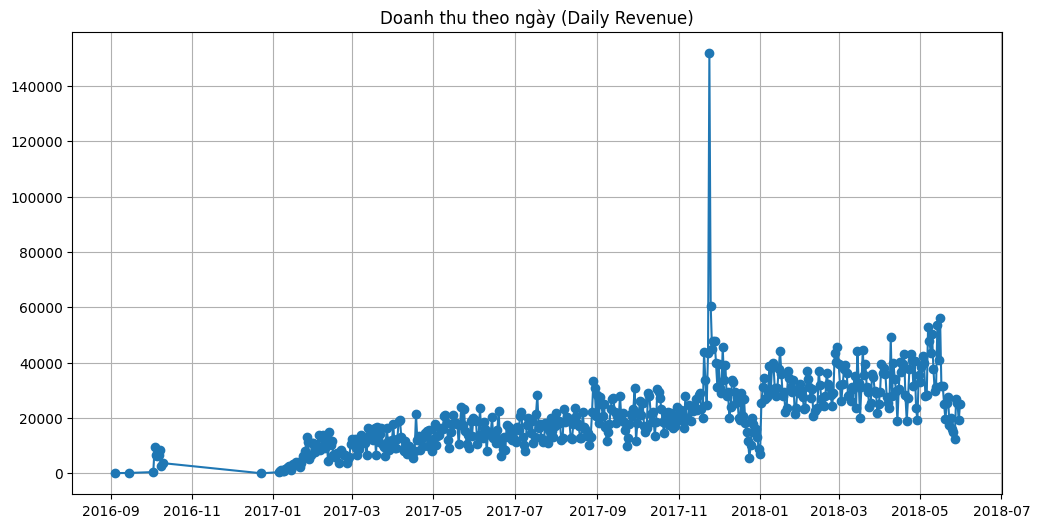

In [16]:
# Vì dữ liệu gốc là từng đơn hàng lẻ (Transactional), ta cần gom lại theo NGÀY
# để model học được: "Ngày hôm nay bán được bao nhiêu tiền?"

df_daily = df.groupby(df['OrderDate'].dt.date)['Revenue'].sum().reset_index()
df_daily.columns = ['Date', 'Revenue']
df_daily['Date'] = pd.to_datetime(df_daily['Date']) # Đảm bảo đúng định dạng

# Sắp xếp theo thời gian (Bắt buộc cho Time Series)
df_daily = df_daily.sort_values('Date')

# Vẽ thử biểu đồ xem xu hướng
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Date'], df_daily['Revenue'], marker='o', linestyle='-')
plt.title('Doanh thu theo ngày (Daily Revenue)')
plt.grid(True)
plt.show()

# 4. TẠO BIẾN ĐẶC TRƯNG (FEATURE ENGINEERING) - Phần quan trọng nhất

## 1. Gom nhóm theo ngày (Aggregations)

In [17]:
# Thay vì chỉ tính Tổng tiền (Sum), ta tính thêm Số đơn (Count) để biết sức mua
df_daily = df.groupby(df['OrderDate'].dt.date).agg({
    'Revenue': 'sum',
    'product_id': 'count' # Đếm số lượng sản phẩm bán ra
}).reset_index()

# Đổi tên cột cho dễ hiểu
df_daily.columns = ['Date', 'Revenue', 'Item_Count']
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily = df_daily.sort_values('Date')

## 2. TẠO BIẾN ĐẶC TRƯNG (FEATURE ENGINEERING)

In [18]:
# --- A. Biến Ngày Lễ (Holiday Events) 🏖️ ---
# Olist là sàn thương mại điện tử Brazil -> Lấy lịch Brazil
br_holidays = holidays.Brazil()

# Tạo cột: 1 là ngày lễ, 0 là ngày thường
df_daily['Is_Holiday'] = df_daily['Date'].apply(lambda x: 1 if x in br_holidays else 0)

# --- B. Biến Giá Trung Bình (Average Price) 🏷️ ---
# Logic: Doanh thu / Số lượng = Giá trung bình mỗi món
# Giúp Model phát hiện đợt Sale (Giá TB giảm -> Doanh thu tăng)
df_daily['Avg_Price'] = df_daily['Revenue'] / df_daily['Item_Count']

# --- C. Các biến Quá khứ (Lag & Trend) ---
# Lag 1: Doanh thu hôm qua
df_daily['Lag_1'] = df_daily['Revenue'].shift(1)
# Lag 7: Doanh thu tuần trước (Tính chu kỳ tuần)
df_daily['Lag_7'] = df_daily['Revenue'].shift(7)
# Rolling 7: Xu hướng trung bình 7 ngày
df_daily['Rolling_Mean_7'] = df_daily['Revenue'].rolling(window=7).mean()

# --- D. Biến Thời gian cơ bản ---
df_daily['DayOfWeek'] = df_daily['Date'].dt.dayofweek # 0=Thứ 2, 6=CN
df_daily['Month'] = df_daily['Date'].dt.month
df_daily['Is_Weekend'] = df_daily['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

## 3. LÀM SẠCH (Xóa NaN do Lag tạo ra)

In [19]:
df_train = df_daily.dropna()

print(f"Kích thước dữ liệu train: {df_train.shape}")
print("\n--- DỮ LIỆU SAU KHI NÂNG CẤP (10 dòng đầu) ---")
display(df_train.head(10))

Kích thước dữ liệu train: (516, 11)

--- DỮ LIỆU SAU KHI NÂNG CẤP (10 dòng đầu) ---


,Date,Revenue,Item_Count,Is_Holiday,Avg_Price,Lag_1,Lag_7,Rolling_Mean_7,DayOfWeek,Month,Is_Weekend
7,2016-10-08,8306.86,43,0,193.182791,6728.25,72.89,5438.357143,5,10,1
8,2016-10-09,2519.20,27,0,93.303704,8306.86,134.97,5778.961429,6,10,1
9,2016-10-10,3692.57,40,0,92.314250,2519.20,441.98,6243.331429,0,10,0
10,2016-12-23,10.90,1,0,10.900000,3692.57,9571.16,4877.580000,4,12,0
11,2017-01-05,396.90,32,0,12.403125,10.90,6589.56,3992.914286,3,1,0
12,2017-01-06,916.38,4,0,229.095000,396.90,6295.72,3224.437143,4,1,0
13,2017-01-07,1351.90,5,0,270.380000,916.38,6728.25,2456.387143,5,1,1
14,2017-01-08,709.58,6,0,118.263333,1351.90,8306.86,1371.061429,6,1,1
15,2017-01-09,673.79,6,0,112.298333,709.58,2519.20,1107.431429,0,1,0
16,2017-01-10,1434.87,6,0,239.145000,673.79,3692.57,784.902857,1,1,0


## 4. KIỂM TRA TƯƠNG QUAN (CORRELATION)

In [20]:
# Xem thử Doanh thu có liên quan gì đến Giá hay Ngày lễ không?
print("\n--- MA TRẬN TƯƠNG QUAN ---")
cols_to_check = ['Revenue', 'Item_Count', 'Avg_Price', 'Is_Holiday', 'Is_Weekend']
display(df_train[cols_to_check].corr())


--- MA TRẬN TƯƠNG QUAN ---


,Revenue,Item_Count,Avg_Price,Is_Holiday,Is_Weekend
Revenue,1.000000,0.967639,0.063468,-0.055395,-0.224745
Item_Count,0.967639,1.000000,-0.127654,-0.050132,-0.219561
Avg_Price,0.063468,-0.127654,1.000000,-0.029379,-0.002098
Is_Holiday,-0.055395,-0.050132,-0.029379,1.000000,-0.069424
Is_Weekend,-0.224745,-0.219561,-0.002098,-0.069424,1.000000


# 5. LÀM SẠCH LẦN CUỐI (Clean NaN)

In [21]:
# Vì các dòng đầu tiên sẽ bị NaN do phép shift (Lag), ta cần xóa đi
df_train = df_daily.dropna()

print(f"\nDữ liệu sẵn sàng để train Model: {len(df_train)} dòng")
# Lưu file để dùng cho bước Train
# df_train.to_csv('data/processed/training_data.csv', index=False)


Dữ liệu sẵn sàng để train Model: 516 dòng
